# Fine-Tuning OpenCLIP

This notebook is an implementation of [OpenCLIP](https://github.com/mlfoundations/open_clip) finetuning with [WiSE-FT](https://github.com/mlfoundations/wise-ft) method for the Ottoman Nature in Travelogues [(ONiT) project](https://onit.oeaw.ac.at/).

Two fine-tuning variants are experimented with:
1) fine-tuning of a linear classifier on top of frozen OpenCLIP representation network (linear probing);
2) end-to-end fine-tuning of OpenCLIP with a linear classifier on top (contrastive learning).

More detailed documentation & final code follows. WORK IN PROGRESS...

In [1]:
# Import packages
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import torch.distributed as dist
from PIL import Image
import pandas as pd
import os
import numpy as np
import math
import open_clip
from tqdm.notebook import tqdm
import time
from torch.utils.tensorboard import SummaryWriter
import random

2023-09-27 16:38:50.973723: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 16:38:51.023085: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 16:38:52.318677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load pre-trained model

In [2]:
# List available models
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commo

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # If using GPU then use mixed precision training.
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion400m_e31', device=device, jit=False) #Must set jit=False for training

## Image preprocessing parameters

In [4]:
# Import image preprocessing packages
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

# Define custom image preprocessing parameters
BATCH_SIZE = 128
IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
train_val_split_ratio = 0.8

# Define pad function (add black borders to keep aspect ratio)
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'constant')

# Define custom preprocess function
preprocess = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# Define preprocess for preview
preprocess_preview = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    #transforms.Normalize(MEAN, STD)
])

# Define preprocess for thumbnail
preprocess_thumb = transforms.Compose([
    SquarePad(),
    transforms.Resize((50, 50)),
])

## Text preprocessing: Load tokenizer

In [5]:
# Import text preprocessing packages
from open_clip import tokenizer

tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [6]:
tokenizer

<function open_clip.tokenizer.tokenize(texts: Union[str, List[str]], context_length: int = 77) -> torch.LongTensor>

## Load data

In [7]:
# Data paths
img_dir = 'images'
data_subset_csv = '~/storage/ONiT-CLIP/data/nature_subset_cleaned4FT_GT.csv'

In [8]:
# Load CSV file with filenames, captions, and image paths
data_full = pd.read_csv(data_subset_csv, sep='|', na_filter=False)
data_full = data_full.dropna()

# Load the image paths, filenames, and captions from a CSV file into lists
image_filenames = data_full["filename"].tolist()
image_captions = data_full["annotation"].tolist()
labels = data_full["label"].tolist()

In [9]:
# Load image paths
image_paths = []
for image_filename in image_filenames:
    img_path = os.path.join(img_dir, image_filename)
    image_paths.append(img_path)

In [10]:
data_full

,filename,annotation,path,index,label,class number
0,embhab_hab_li77441_pic142.jpg,"Image depicting hourglass, animal",images/embhab_hab_li77441_pic142.jpg,2,'animals',1
1,IIHIM_-739492654.jpg,Image depicting insect,images/IIHIM_-739492654.jpg,3,'animals',1
2,embepu_su1724_pic10005.jpg,"Image depicting perfection, soul, Divotione, R...",images/embepu_su1724_pic10005.jpg,4,'animals',1
3,IIHIM_-1674073675.jpg,"Image depicting hunter, huntress, conversation...",images/IIHIM_-1674073675.jpg,6,'animals',1
4,IIHIM_-1186622624.jpg,"Image depicting Mostri, animal, monster, shape...",images/IIHIM_-1186622624.jpg,7,'animals',1
...,...,...,...,...,...,...
22711,IIHIM_RIJKS_-808802799.jpg,"Image depicting globe, tool, writing tool",images/IIHIM_RIJKS_-808802799.jpg,34717,'maps',4
22712,IIHIM_RIJKS_642351449.jpg,Image depicting city,images/IIHIM_RIJKS_642351449.jpg,34718,'maps',4
22713,IIHIM_RIJKS_1638784261.jpg,"Image depicting city, battle, fortress",images/IIHIM_RIJKS_1638784261.jpg,34721,'maps',4
22714,128c4_172v_173r.jpg,"Image depicting latitude, longitude, continent",images/128c4_172v_173r.jpg,34722,'maps',4


## Define dataset class and data loader

In [11]:
# Define dataset class
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_captions, transform=None):
        self.image_paths = image_paths
        self.image_captions = image_captions
        self.preprocess = preprocess
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        caption = self.image_captions[idx]
        image_path = self.image_paths[idx]
        try:
            with open(image_path, 'rb') as f:
                image = Image.open(f).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image file {image_path} not found. Skipping...")
            pass
        image_prep = preprocess(image)
        caption_prep = tokenizer(caption)[0]
        return image_prep, caption_prep

In [12]:
# Define your data loader
dataset = ImageDataset(image_paths, image_captions)
data_loader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

## Split into training and validation data sets
# Total samples length
total_samples = len(image_paths)

# Calculate the sizes of the training and validation sets
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

# Use random_split to create training and validation datasets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define your data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Preview data

In [13]:
import matplotlib.pyplot as plt
import textwrap

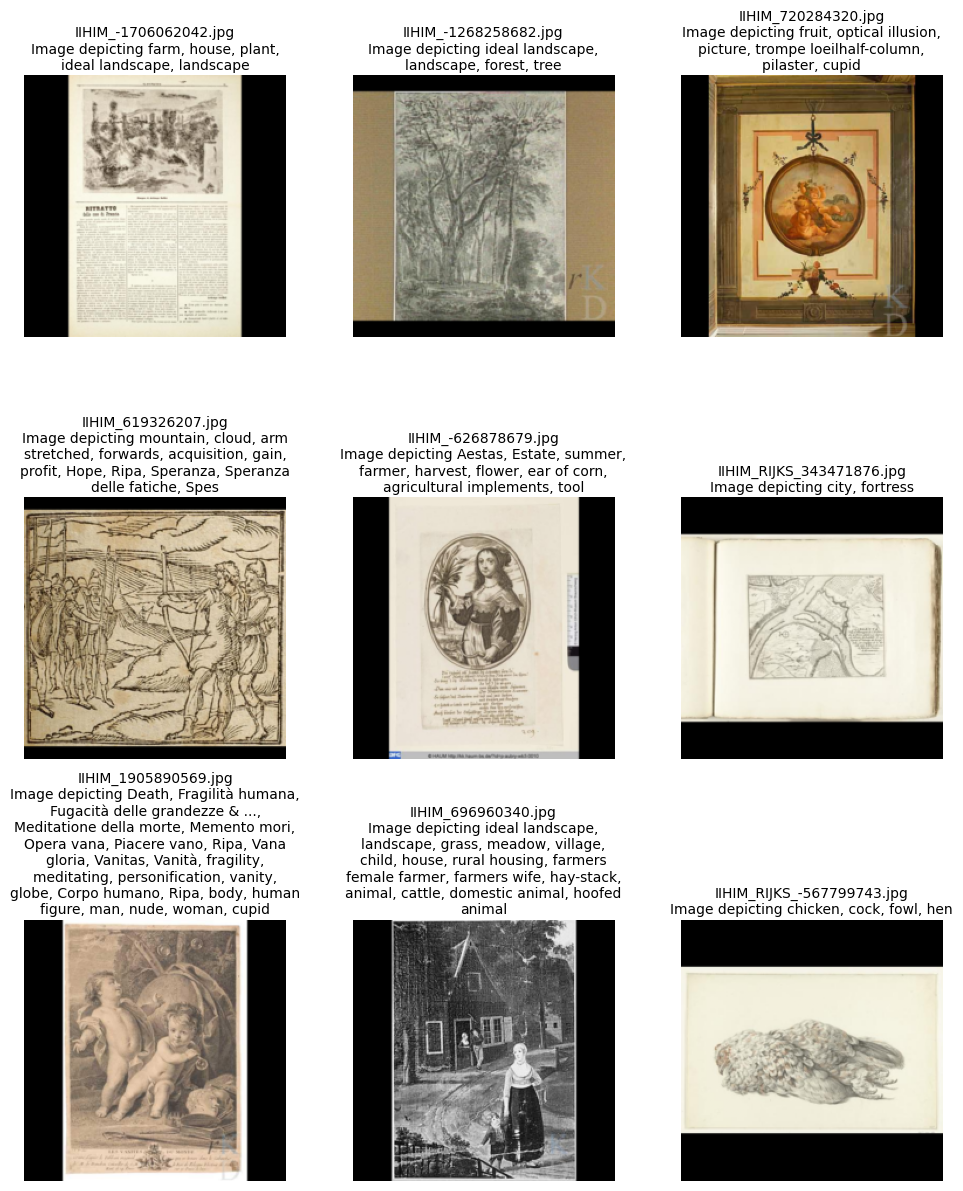

In [14]:
# Define the number of rows and columns in the preview table
num_rows = 3
num_cols = 3
num_images = num_rows * num_cols

# Shuffle the indices of the images and captions from the full dataset
indices = list(range(len(image_paths)))
random.shuffle(indices)

# Load the images and captions for the preview and results tables
images = []
indx = []
for i, index in enumerate(indices[:num_images]):
    image = Image.open(image_paths[index]).convert("RGB")
    #print('Image path: ', image_paths[index])
    images.append(image)
    indx.append(index)
    if i == num_images - 1:
        break

# Create lists of captions, filenames, groundtruth, and classnumber of the set of images
captions = [image_captions[index] for index in indices[:num_images]]
filenames = [image_filenames[index] for index in indices[:num_images]]
#groundtruth = [ground_truth[index] for index in indices[:num_images]]
#classnumber = [class_number[index] for index in indices[:num_images]]

# Preprocess the images with the torchvision transform
preprocessed_images = torch.stack([preprocess_preview(image) for image in images])

# Create the preview table
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(preprocessed_images[i].permute(1, 2, 0))
    ax.axis("off")
    
    # Add the caption as the title
    longtitle = '\n'.join(textwrap.wrap(captions[i], width=40))
    filename = filenames[i]
    title = ax.set_title(filename + "\n" + longtitle, fontsize=10, clip_on=True, wrap=True)
    title.set_position([.5, .9])

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.5)

# Show the preview table
plt.tight_layout()
plt.show()

## Fine-tuning parameters

In [15]:
# Finetuning parameters
LR=5e-5 
EPOCHS = 20
num_batches = len(train_loader)
weight_decay=0.2
num_classes = 4

freeze_encoder = False # Set to False for end-to-end fine-tuning; Set to True to fine-tune the linear classifier only

SAVE_MODEL = 'CLIP-finetune/models/' # Specify path to save fine-tuned model
CACHE_DIR = os.path.join(SAVE_MODEL, "cache/") # Directory for caching features and encoder

# TensorBoard writer
writer = SummaryWriter(log_dir=SAVE_MODEL)

In [16]:
# Define optimizer and loss function
params = [p for p in model.parameters() if p.requires_grad] #filters out only the parameters that require gradients, and these are the parameters that the optimizer will update during the training process.
optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=weight_decay)
loss_fn = torch.nn.CrossEntropyLoss()

In [17]:
# Access the intermediate hidden layer
hidden_layer = model.visual.transformer.resblocks[-1].mlp.c_proj

# Display the hidden layer's configuration
print(hidden_layer)

Linear(in_features=3072, out_features=768, bias=True)


In [18]:
class CustomModel(nn.Module):
    def __init__(self, model, num_classes):
        super(CustomModel, self).__init__()
        self.model = model
        self.fc = nn.Linear(hidden_layer.out_features, num_classes)

    def forward(self, images, captions):
        image_outputs = self.model.encode_image(images)
        caption_outputs = self.model.encode_text(captions)
        
        #print('Image outputs shape: ', image_outputs.shape)
        #print('Caption outputs shape: ', caption_outputs.shape)
        return image_outputs, caption_outputs

custom_model = CustomModel(model, num_classes)

print(custom_model)

CustomModel(
  (model): CLIP(
    (visual): VisionTransformer(
      (patchnorm_pre_ln): Identity()
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-11): 12 x ResidualAttentionBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ls_2)

In [20]:
devices = list(range(torch.cuda.device_count()))

## DOES NOT WORK
# Initialize PyTorch distributed backend (if not already initialized)
#if not dist.is_initialized():
#    dist.init_process_group(backend='nccl')
#model = nn.parallel.DistributedDataParallel(model)

## USE THIS TO PARALLELIZE
#model = model.cuda() # Push model to (multiple) GPUs
#model = torch.nn.DataParallel(model, device_ids=devices) # For parallelization on multiple GPUs (wrapper)

print('Using devices', devices)
print('Torch CUDA device count: ', torch.cuda.device_count())

print(model.train())

Using devices [0]
Torch CUDA device count:  1
CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
     

## Linear-probe

In [21]:
## TODO
'''
# Get features with loaded image encoder of original model as input for fine-tuning the linear classifier
from sklearn.linear_model import LogisticRegression

# Get Features function
def get_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            features = model.encode_image(images.to(device))
            
            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate image features
features, labels = get_features(dataset)
'''

'\n# Get features with loaded image encoder of original model as input for fine-tuning the linear classifier\nfrom sklearn.linear_model import LogisticRegression\n\n# Get Features function\ndef get_features(dataset):\n    all_features = []\n    all_labels = []\n\n    with torch.no_grad():\n        for images, labels in tqdm(data_loader):\n            features = model.encode_image(images.to(device))\n            \n            all_features.append(features)\n            all_labels.append(labels)\n\n    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()\n\n# Calculate image features\nfeatures, labels = get_features(dataset)\n'

In [22]:
'''
# Define data loader for training of linear classifier

if freeze_encoder == True:
    dataset = FeatureDataset(image_encoder, dataset, device)
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
else:
    dataset = dataset
    data_loader = data_loader
    '''

'\n# Define data loader for training of linear classifier\n\nif freeze_encoder == True:\n    dataset = FeatureDataset(image_encoder, dataset, device)\n    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)\nelse:\n    dataset = dataset\n    data_loader = data_loader\n    '

In [23]:
'''
dataset

print(len(dataset))
#print(dataset[199])
'''

'\ndataset\n\nprint(len(dataset))\n#print(dataset[199])\n'

In [24]:
'''
print(image_classifier.classification_head.train())
'''

'\nprint(image_classifier.classification_head.train())\n'

# Fine-Tuning OpenCLIP

In [25]:
# Automatic mixed precision fine-tuning end-to-end
scaler = GradScaler()

print('Fine-tuning end-to-end')
model = custom_model
train_loader=train_loader

for epoch in range(EPOCHS):
    print(f"Batch Size: {BATCH_SIZE}")
    model.train()
    running_loss = 0.0

    # Create the progress bar
    data_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True, dynamic_ncols=False)
    
    for batch_idx, (image_prep, caption_prep) in enumerate(data_loader_iter):
        start_time = time.time()
        
        optimizer.zero_grad()

        #caption_prep = caption_prep.unsqueeze(2).unsqueeze(3)
        
        #print(f'Batch {batch_idx +1}:')
        #print(f'Images shape: {image_prep.shape}')
        #print(f'Captions shape: {caption_prep.shape}')
        
        images = image_prep.to(device)
        captions = caption_prep.to(device)
        data_time = time.time() - start_time

        with autocast():
            outputs = model(images, captions)
            #print('Outputs: ', outputs)
            logits_per_image = outputs[0]
            logits_per_caption = outputs[1]
            #print('Logits per image: ', logits_per_image.shape)
            #print('Logits per caption: ', logits_per_caption.shape)
            
            ### Computation of ground_truth and contrastive loss taken from https://github.com/openai/CLIP/issues/83
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
            loss = (loss_fn(logits_per_image,ground_truth) + loss_fn(logits_per_caption,ground_truth))/2 # Compute contrastive loss

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        torch.nn.utils.clip_grad_norm_(params, 1.0)
        
        running_loss += loss.item()
        batch_time = time.time() - start_time

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            writer.add_scalar("Training Loss (over the batches)", loss.item(), epoch * len(train_loader) + batch_idx)
            print("Batch Training Loss", loss.item())
            print(f"Epoch: {epoch + 1}/{EPOCHS}, Batch: {batch_idx + 1}/{len(train_loader)}")

        if i % 100 == 0:
            percent_complete = 100 * i / len(data_loader)
            print(
                f"Loss: {loss.item():.6f}\tData (t) {data_time:.3f}\tBatch (t) {batch_time:.3f}", flush=True
            )
    running_loss /= len(train_loader)
    # train_accuracy = correct / total

    writer.add_scalar("Training Loss (over the epochs)", running_loss, epoch)
    # writer.add_scalar("Training Accuracy (over the epochs)", train_accuracy, epoch)
    print("\nTraining Loss", running_loss)
    # print("\nTraining Accuracy: ", train_accuracy)

Fine-tuning end-to-end
Batch Size: 128


Epoch 1/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 5.630706787109375
Epoch: 1/20, Batch: 10/142
Batch Training Loss 5.408294677734375
Epoch: 1/20, Batch: 20/142
Batch Training Loss 5.24261474609375
Epoch: 1/20, Batch: 30/142
Batch Training Loss 5.1248321533203125
Epoch: 1/20, Batch: 40/142
Batch Training Loss 5.0479278564453125
Epoch: 1/20, Batch: 50/142
Batch Training Loss 5.001708984375
Epoch: 1/20, Batch: 60/142
Batch Training Loss 4.9645538330078125
Epoch: 1/20, Batch: 70/142
Batch Training Loss 4.941558837890625
Epoch: 1/20, Batch: 80/142
Batch Training Loss 4.9263153076171875
Epoch: 1/20, Batch: 90/142
Batch Training Loss 4.914337158203125
Epoch: 1/20, Batch: 100/142
Batch Training Loss 4.9072418212890625
Epoch: 1/20, Batch: 110/142
Batch Training Loss 4.8971405029296875
Epoch: 1/20, Batch: 120/142
Batch Training Loss 4.892669677734375
Epoch: 1/20, Batch: 130/142
Batch Training Loss 4.8900299072265625
Epoch: 1/20, Batch: 140/142
Batch Training Loss 4.887900352478027
Epoch: 1/20, Batch: 142/142

Training Loss 5

Epoch 2/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.88360595703125
Epoch: 2/20, Batch: 10/142
Batch Training Loss 4.8796234130859375
Epoch: 2/20, Batch: 20/142
Batch Training Loss 4.879364013671875
Epoch: 2/20, Batch: 30/142
Batch Training Loss 4.8742828369140625
Epoch: 2/20, Batch: 40/142
Batch Training Loss 4.873779296875
Epoch: 2/20, Batch: 50/142
Batch Training Loss 4.8729095458984375
Epoch: 2/20, Batch: 60/142
Batch Training Loss 4.8714752197265625
Epoch: 2/20, Batch: 70/142
Batch Training Loss 4.8708343505859375
Epoch: 2/20, Batch: 80/142
Batch Training Loss 4.8683624267578125
Epoch: 2/20, Batch: 90/142
Batch Training Loss 4.86834716796875
Epoch: 2/20, Batch: 100/142
Batch Training Loss 4.8669281005859375
Epoch: 2/20, Batch: 110/142
Batch Training Loss 4.8631134033203125
Epoch: 2/20, Batch: 120/142
Batch Training Loss 4.865692138671875
Epoch: 2/20, Batch: 130/142
Batch Training Loss 4.8641204833984375
Epoch: 2/20, Batch: 140/142
Batch Training Loss 4.86354923248291
Epoch: 2/20, Batch: 142/142

Training Loss 4

Epoch 3/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.8625335693359375
Epoch: 3/20, Batch: 10/142
Batch Training Loss 4.8622283935546875
Epoch: 3/20, Batch: 20/142
Batch Training Loss 4.8614044189453125
Epoch: 3/20, Batch: 30/142
Batch Training Loss 4.861175537109375
Epoch: 3/20, Batch: 40/142
Batch Training Loss 4.8643798828125
Epoch: 3/20, Batch: 50/142
Batch Training Loss 4.862640380859375
Epoch: 3/20, Batch: 60/142
Batch Training Loss 4.86334228515625
Epoch: 3/20, Batch: 70/142
Batch Training Loss 4.8604888916015625
Epoch: 3/20, Batch: 80/142
Batch Training Loss 4.857879638671875
Epoch: 3/20, Batch: 90/142
Batch Training Loss 4.8572540283203125
Epoch: 3/20, Batch: 100/142
Batch Training Loss 4.861175537109375
Epoch: 3/20, Batch: 110/142
Batch Training Loss 4.8585968017578125
Epoch: 3/20, Batch: 120/142
Batch Training Loss 4.8592529296875
Epoch: 3/20, Batch: 130/142
Batch Training Loss 4.8575286865234375
Epoch: 3/20, Batch: 140/142
Batch Training Loss 4.859847545623779
Epoch: 3/20, Batch: 142/142

Training Loss 4.

Epoch 4/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.8575592041015625
Epoch: 4/20, Batch: 10/142
Batch Training Loss 4.8576812744140625
Epoch: 4/20, Batch: 20/142
Batch Training Loss 4.856475830078125
Epoch: 4/20, Batch: 30/142
Batch Training Loss 4.8579254150390625
Epoch: 4/20, Batch: 40/142
Batch Training Loss 4.857452392578125
Epoch: 4/20, Batch: 50/142
Batch Training Loss 4.8555450439453125
Epoch: 4/20, Batch: 60/142
Batch Training Loss 4.8564453125
Epoch: 4/20, Batch: 70/142
Batch Training Loss 4.8570098876953125
Epoch: 4/20, Batch: 80/142
Batch Training Loss 4.8562164306640625
Epoch: 4/20, Batch: 90/142
Batch Training Loss 4.860870361328125
Epoch: 4/20, Batch: 100/142
Batch Training Loss 4.856536865234375
Epoch: 4/20, Batch: 110/142
Batch Training Loss 4.858428955078125
Epoch: 4/20, Batch: 120/142
Batch Training Loss 4.8552703857421875
Epoch: 4/20, Batch: 130/142
Batch Training Loss 4.857452392578125
Epoch: 4/20, Batch: 140/142
Batch Training Loss 4.855185508728027
Epoch: 4/20, Batch: 142/142

Training Loss 4.

Epoch 5/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.8544769287109375
Epoch: 5/20, Batch: 10/142
Batch Training Loss 4.85888671875
Epoch: 5/20, Batch: 20/142
Batch Training Loss 4.8569183349609375
Epoch: 5/20, Batch: 30/142
Batch Training Loss 4.856964111328125
Epoch: 5/20, Batch: 40/142
Batch Training Loss 4.85577392578125
Epoch: 5/20, Batch: 50/142
Batch Training Loss 4.858154296875
Epoch: 5/20, Batch: 60/142
Batch Training Loss 4.8550872802734375
Epoch: 5/20, Batch: 70/142
Batch Training Loss 4.852294921875
Epoch: 5/20, Batch: 80/142
Batch Training Loss 4.85406494140625
Epoch: 5/20, Batch: 90/142
Batch Training Loss 4.8568878173828125
Epoch: 5/20, Batch: 100/142
Batch Training Loss 4.8558807373046875
Epoch: 5/20, Batch: 110/142
Batch Training Loss 4.854644775390625
Epoch: 5/20, Batch: 120/142
Batch Training Loss 4.8542633056640625
Epoch: 5/20, Batch: 130/142
Batch Training Loss 4.854217529296875
Epoch: 5/20, Batch: 140/142
Batch Training Loss 4.85422420501709
Epoch: 5/20, Batch: 142/142

Training Loss 4.855570128

Epoch 6/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.855316162109375
Epoch: 6/20, Batch: 10/142
Batch Training Loss 4.8561553955078125
Epoch: 6/20, Batch: 20/142
Batch Training Loss 4.852508544921875
Epoch: 6/20, Batch: 30/142
Batch Training Loss 4.854736328125
Epoch: 6/20, Batch: 40/142
Batch Training Loss 4.853607177734375
Epoch: 6/20, Batch: 50/142
Batch Training Loss 4.8549957275390625
Epoch: 6/20, Batch: 60/142
Batch Training Loss 4.8543243408203125
Epoch: 6/20, Batch: 70/142
Batch Training Loss 4.855804443359375
Epoch: 6/20, Batch: 80/142
Batch Training Loss 4.8536224365234375
Epoch: 6/20, Batch: 90/142
Batch Training Loss 4.8561248779296875
Epoch: 6/20, Batch: 100/142
Batch Training Loss 4.853271484375
Epoch: 6/20, Batch: 110/142
Batch Training Loss 4.8536529541015625
Epoch: 6/20, Batch: 120/142
Batch Training Loss 4.853607177734375
Epoch: 6/20, Batch: 130/142
Batch Training Loss 4.8539276123046875
Epoch: 6/20, Batch: 140/142
Batch Training Loss 4.85302734375
Epoch: 6/20, Batch: 142/142

Training Loss 4.85448

Epoch 7/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.8555908203125
Epoch: 7/20, Batch: 10/142
Batch Training Loss 4.8526153564453125
Epoch: 7/20, Batch: 20/142
Batch Training Loss 4.8566741943359375
Epoch: 7/20, Batch: 30/142
Batch Training Loss 4.852874755859375
Epoch: 7/20, Batch: 40/142
Batch Training Loss 4.854461669921875
Epoch: 7/20, Batch: 50/142
Batch Training Loss 4.8531646728515625
Epoch: 7/20, Batch: 60/142
Batch Training Loss 4.8549652099609375
Epoch: 7/20, Batch: 70/142
Batch Training Loss 4.8517913818359375
Epoch: 7/20, Batch: 80/142
Batch Training Loss 4.854461669921875
Epoch: 7/20, Batch: 90/142
Batch Training Loss 4.8547821044921875
Epoch: 7/20, Batch: 100/142
Batch Training Loss 4.853179931640625
Epoch: 7/20, Batch: 110/142
Batch Training Loss 4.853607177734375
Epoch: 7/20, Batch: 120/142
Batch Training Loss 4.8534088134765625
Epoch: 7/20, Batch: 130/142
Batch Training Loss 4.853240966796875
Epoch: 7/20, Batch: 140/142
Batch Training Loss 4.853137493133545
Epoch: 7/20, Batch: 142/142

Training Loss

Epoch 8/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.854705810546875
Epoch: 8/20, Batch: 10/142
Batch Training Loss 4.85296630859375
Epoch: 8/20, Batch: 20/142
Batch Training Loss 4.8530731201171875
Epoch: 8/20, Batch: 30/142
Batch Training Loss 4.852508544921875
Epoch: 8/20, Batch: 40/142
Batch Training Loss 4.8530120849609375
Epoch: 8/20, Batch: 50/142
Batch Training Loss 4.8521881103515625
Epoch: 8/20, Batch: 60/142
Batch Training Loss 4.8526458740234375
Epoch: 8/20, Batch: 70/142
Batch Training Loss 4.8540496826171875
Epoch: 8/20, Batch: 80/142
Batch Training Loss 4.853912353515625
Epoch: 8/20, Batch: 90/142
Batch Training Loss 4.85296630859375
Epoch: 8/20, Batch: 100/142
Batch Training Loss 4.852081298828125
Epoch: 8/20, Batch: 110/142
Batch Training Loss 4.854339599609375
Epoch: 8/20, Batch: 120/142
Batch Training Loss 4.8553009033203125
Epoch: 8/20, Batch: 130/142
Batch Training Loss 4.8521728515625
Epoch: 8/20, Batch: 140/142
Batch Training Loss 4.85373592376709
Epoch: 8/20, Batch: 142/142

Training Loss 4.8

Epoch 9/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.8527679443359375
Epoch: 9/20, Batch: 10/142
Batch Training Loss 4.8558197021484375
Epoch: 9/20, Batch: 20/142
Batch Training Loss 4.8519134521484375
Epoch: 9/20, Batch: 30/142
Batch Training Loss 4.855010986328125
Epoch: 9/20, Batch: 40/142
Batch Training Loss 4.8527069091796875
Epoch: 9/20, Batch: 50/142
Batch Training Loss 4.8521575927734375
Epoch: 9/20, Batch: 60/142
Batch Training Loss 4.8552093505859375
Epoch: 9/20, Batch: 70/142
Batch Training Loss 4.8527984619140625
Epoch: 9/20, Batch: 80/142
Batch Training Loss 4.8543701171875
Epoch: 9/20, Batch: 90/142
Batch Training Loss 4.8514404296875
Epoch: 9/20, Batch: 100/142
Batch Training Loss 4.851531982421875
Epoch: 9/20, Batch: 110/142
Batch Training Loss 4.854644775390625
Epoch: 9/20, Batch: 120/142
Batch Training Loss 4.8531341552734375
Epoch: 9/20, Batch: 130/142
Batch Training Loss 4.8529510498046875
Epoch: 9/20, Batch: 140/142
Batch Training Loss 4.8521928787231445
Epoch: 9/20, Batch: 142/142

Training Los

Epoch 10/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.854949951171875
Epoch: 10/20, Batch: 10/142
Batch Training Loss 4.851959228515625
Epoch: 10/20, Batch: 20/142
Batch Training Loss 4.853240966796875
Epoch: 10/20, Batch: 30/142
Batch Training Loss 4.8506927490234375
Epoch: 10/20, Batch: 40/142
Batch Training Loss 4.8563690185546875
Epoch: 10/20, Batch: 50/142
Batch Training Loss 4.852386474609375
Epoch: 10/20, Batch: 60/142
Batch Training Loss 4.8495330810546875
Epoch: 10/20, Batch: 70/142
Batch Training Loss 4.85443115234375
Epoch: 10/20, Batch: 80/142
Batch Training Loss 4.8531494140625
Epoch: 10/20, Batch: 90/142
Batch Training Loss 4.8524017333984375
Epoch: 10/20, Batch: 100/142
Batch Training Loss 4.8547515869140625
Epoch: 10/20, Batch: 110/142
Batch Training Loss 4.8511810302734375
Epoch: 10/20, Batch: 120/142
Batch Training Loss 4.8539581298828125
Epoch: 10/20, Batch: 130/142
Batch Training Loss 4.8525238037109375
Epoch: 10/20, Batch: 140/142
Batch Training Loss 4.853153228759766
Epoch: 10/20, Batch: 142/142

Epoch 11/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.853057861328125
Epoch: 11/20, Batch: 10/142
Batch Training Loss 4.8526153564453125
Epoch: 11/20, Batch: 20/142
Batch Training Loss 4.853607177734375
Epoch: 11/20, Batch: 30/142
Batch Training Loss 4.8525390625
Epoch: 11/20, Batch: 40/142
Batch Training Loss 4.8529815673828125
Epoch: 11/20, Batch: 50/142
Batch Training Loss 4.852203369140625
Epoch: 11/20, Batch: 60/142
Batch Training Loss 4.8531494140625
Epoch: 11/20, Batch: 70/142
Batch Training Loss 4.85296630859375
Epoch: 11/20, Batch: 80/142
Batch Training Loss 4.85296630859375
Epoch: 11/20, Batch: 90/142
Batch Training Loss 4.852447509765625
Epoch: 11/20, Batch: 100/142
Batch Training Loss 4.853118896484375
Epoch: 11/20, Batch: 110/142
Batch Training Loss 4.85333251953125
Epoch: 11/20, Batch: 120/142
Batch Training Loss 4.8531646728515625
Epoch: 11/20, Batch: 130/142
Batch Training Loss 4.854705810546875
Epoch: 11/20, Batch: 140/142
Batch Training Loss 4.853972434997559
Epoch: 11/20, Batch: 142/142

Training L

Epoch 12/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.8535308837890625
Epoch: 12/20, Batch: 10/142
Batch Training Loss 4.8538665771484375
Epoch: 12/20, Batch: 20/142
Batch Training Loss 4.8535003662109375
Epoch: 12/20, Batch: 30/142
Batch Training Loss 4.8518524169921875
Epoch: 12/20, Batch: 40/142
Batch Training Loss 4.85406494140625
Epoch: 12/20, Batch: 50/142
Batch Training Loss 4.8522491455078125
Epoch: 12/20, Batch: 60/142
Batch Training Loss 4.8510589599609375
Epoch: 12/20, Batch: 70/142
Batch Training Loss 4.851806640625
Epoch: 12/20, Batch: 80/142
Batch Training Loss 4.851715087890625
Epoch: 12/20, Batch: 90/142
Batch Training Loss 4.851165771484375
Epoch: 12/20, Batch: 100/142
Batch Training Loss 4.852569580078125
Epoch: 12/20, Batch: 110/142
Batch Training Loss 4.853057861328125
Epoch: 12/20, Batch: 120/142
Batch Training Loss 4.8555145263671875
Epoch: 12/20, Batch: 130/142
Batch Training Loss 4.8520965576171875
Epoch: 12/20, Batch: 140/142
Batch Training Loss 4.853924751281738
Epoch: 12/20, Batch: 142/142


Epoch 13/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.8524017333984375
Epoch: 13/20, Batch: 10/142
Batch Training Loss 4.8516693115234375
Epoch: 13/20, Batch: 20/142
Batch Training Loss 4.8524017333984375
Epoch: 13/20, Batch: 30/142
Batch Training Loss 4.8521575927734375
Epoch: 13/20, Batch: 40/142
Batch Training Loss 4.8536224365234375
Epoch: 13/20, Batch: 50/142
Batch Training Loss 4.853515625
Epoch: 13/20, Batch: 60/142
Batch Training Loss 4.8531494140625
Epoch: 13/20, Batch: 70/142
Batch Training Loss 4.854400634765625
Epoch: 13/20, Batch: 80/142
Batch Training Loss 4.85198974609375
Epoch: 13/20, Batch: 90/142
Batch Training Loss 4.8530426025390625
Epoch: 13/20, Batch: 100/142
Batch Training Loss 4.8531036376953125
Epoch: 13/20, Batch: 110/142
Batch Training Loss 4.852508544921875
Epoch: 13/20, Batch: 120/142
Batch Training Loss 4.853668212890625
Epoch: 13/20, Batch: 130/142
Batch Training Loss 4.8500823974609375
Epoch: 13/20, Batch: 140/142
Batch Training Loss 4.8519721031188965
Epoch: 13/20, Batch: 142/142

Tra

Epoch 14/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.852020263671875
Epoch: 14/20, Batch: 10/142
Batch Training Loss 4.855255126953125
Epoch: 14/20, Batch: 20/142
Batch Training Loss 4.8529205322265625
Epoch: 14/20, Batch: 30/142
Batch Training Loss 4.8513641357421875
Epoch: 14/20, Batch: 40/142
Batch Training Loss 4.852386474609375
Epoch: 14/20, Batch: 50/142
Batch Training Loss 4.851837158203125
Epoch: 14/20, Batch: 60/142
Batch Training Loss 4.85211181640625
Epoch: 14/20, Batch: 70/142
Batch Training Loss 4.852813720703125
Epoch: 14/20, Batch: 80/142
Batch Training Loss 4.85223388671875
Epoch: 14/20, Batch: 90/142
Batch Training Loss 4.8546142578125
Epoch: 14/20, Batch: 100/142
Batch Training Loss 4.8527069091796875
Epoch: 14/20, Batch: 110/142
Batch Training Loss 4.85284423828125
Epoch: 14/20, Batch: 120/142
Batch Training Loss 4.8529510498046875
Epoch: 14/20, Batch: 130/142
Batch Training Loss 4.8519287109375
Epoch: 14/20, Batch: 140/142
Batch Training Loss 4.853515625
Epoch: 14/20, Batch: 142/142

Training Los

Epoch 15/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.8521575927734375
Epoch: 15/20, Batch: 10/142
Batch Training Loss 4.8523712158203125
Epoch: 15/20, Batch: 20/142
Batch Training Loss 4.8536529541015625
Epoch: 15/20, Batch: 30/142
Batch Training Loss 4.851959228515625
Epoch: 15/20, Batch: 40/142
Batch Training Loss 4.8515472412109375
Epoch: 15/20, Batch: 50/142
Batch Training Loss 4.853118896484375
Epoch: 15/20, Batch: 60/142
Batch Training Loss 4.8529815673828125
Epoch: 15/20, Batch: 70/142
Batch Training Loss 4.853607177734375
Epoch: 15/20, Batch: 80/142
Batch Training Loss 4.8524932861328125
Epoch: 15/20, Batch: 90/142
Batch Training Loss 4.8516845703125
Epoch: 15/20, Batch: 100/142
Batch Training Loss 4.8536529541015625
Epoch: 15/20, Batch: 110/142
Batch Training Loss 4.852325439453125
Epoch: 15/20, Batch: 120/142
Batch Training Loss 4.850982666015625
Epoch: 15/20, Batch: 130/142
Batch Training Loss 4.853363037109375
Epoch: 15/20, Batch: 140/142
Batch Training Loss 4.853326797485352
Epoch: 15/20, Batch: 142/142

Epoch 16/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.851898193359375
Epoch: 16/20, Batch: 10/142
Batch Training Loss 4.851531982421875
Epoch: 16/20, Batch: 20/142
Batch Training Loss 4.852447509765625
Epoch: 16/20, Batch: 30/142
Batch Training Loss 4.8520965576171875
Epoch: 16/20, Batch: 40/142
Batch Training Loss 4.85186767578125
Epoch: 16/20, Batch: 50/142
Batch Training Loss 4.85321044921875
Epoch: 16/20, Batch: 60/142
Batch Training Loss 4.8526153564453125
Epoch: 16/20, Batch: 70/142
Batch Training Loss 4.85223388671875
Epoch: 16/20, Batch: 80/142
Batch Training Loss 4.8535308837890625
Epoch: 16/20, Batch: 90/142
Batch Training Loss 4.8507537841796875
Epoch: 16/20, Batch: 100/142
Batch Training Loss 4.853271484375
Epoch: 16/20, Batch: 110/142
Batch Training Loss 4.852691650390625
Epoch: 16/20, Batch: 120/142
Batch Training Loss 4.8520050048828125
Epoch: 16/20, Batch: 130/142
Batch Training Loss 4.8539276123046875
Epoch: 16/20, Batch: 140/142
Batch Training Loss 4.853090286254883
Epoch: 16/20, Batch: 142/142

Tra

Epoch 17/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.850555419921875
Epoch: 17/20, Batch: 10/142
Batch Training Loss 4.8525543212890625
Epoch: 17/20, Batch: 20/142
Batch Training Loss 4.8524169921875
Epoch: 17/20, Batch: 30/142
Batch Training Loss 4.8513031005859375
Epoch: 17/20, Batch: 40/142
Batch Training Loss 4.85205078125
Epoch: 17/20, Batch: 50/142
Batch Training Loss 4.851776123046875
Epoch: 17/20, Batch: 60/142
Batch Training Loss 4.85260009765625
Epoch: 17/20, Batch: 70/142
Batch Training Loss 4.85211181640625
Epoch: 17/20, Batch: 80/142
Batch Training Loss 4.851898193359375
Epoch: 17/20, Batch: 90/142
Batch Training Loss 4.85235595703125
Epoch: 17/20, Batch: 100/142
Batch Training Loss 4.8523406982421875
Epoch: 17/20, Batch: 110/142
Batch Training Loss 4.85260009765625
Epoch: 17/20, Batch: 120/142
Batch Training Loss 4.8523101806640625
Epoch: 17/20, Batch: 130/142
Batch Training Loss 4.8520050048828125
Epoch: 17/20, Batch: 140/142
Batch Training Loss 4.852113723754883
Epoch: 17/20, Batch: 142/142

Training

Epoch 18/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.8521270751953125
Epoch: 18/20, Batch: 10/142
Batch Training Loss 4.8525238037109375
Epoch: 18/20, Batch: 20/142
Batch Training Loss 4.8513946533203125
Epoch: 18/20, Batch: 30/142
Batch Training Loss 4.8534088134765625
Epoch: 18/20, Batch: 40/142
Batch Training Loss 4.8532562255859375
Epoch: 18/20, Batch: 50/142
Batch Training Loss 4.85198974609375
Epoch: 18/20, Batch: 60/142
Batch Training Loss 4.8528289794921875
Epoch: 18/20, Batch: 70/142
Batch Training Loss 4.8520355224609375
Epoch: 18/20, Batch: 80/142
Batch Training Loss 4.8521728515625
Epoch: 18/20, Batch: 90/142
Batch Training Loss 4.851470947265625
Epoch: 18/20, Batch: 100/142
Batch Training Loss 4.8520965576171875
Epoch: 18/20, Batch: 110/142
Batch Training Loss 4.8513336181640625
Epoch: 18/20, Batch: 120/142
Batch Training Loss 4.8514862060546875
Epoch: 18/20, Batch: 130/142
Batch Training Loss 4.8522491455078125
Epoch: 18/20, Batch: 140/142
Batch Training Loss 4.8528852462768555
Epoch: 18/20, Batch: 142

Epoch 19/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.853759765625
Epoch: 19/20, Batch: 10/142
Batch Training Loss 4.852294921875
Epoch: 19/20, Batch: 20/142
Batch Training Loss 4.8524169921875
Epoch: 19/20, Batch: 30/142
Batch Training Loss 4.8514862060546875
Epoch: 19/20, Batch: 40/142
Batch Training Loss 4.85272216796875
Epoch: 19/20, Batch: 50/142
Batch Training Loss 4.8510589599609375
Epoch: 19/20, Batch: 60/142
Batch Training Loss 4.8517303466796875
Epoch: 19/20, Batch: 70/142
Batch Training Loss 4.8525543212890625
Epoch: 19/20, Batch: 80/142
Batch Training Loss 4.8518524169921875
Epoch: 19/20, Batch: 90/142
Batch Training Loss 4.85150146484375
Epoch: 19/20, Batch: 100/142
Batch Training Loss 4.851837158203125
Epoch: 19/20, Batch: 110/142
Batch Training Loss 4.85076904296875
Epoch: 19/20, Batch: 120/142
Batch Training Loss 4.852752685546875
Epoch: 19/20, Batch: 130/142
Batch Training Loss 4.85284423828125
Epoch: 19/20, Batch: 140/142
Batch Training Loss 4.851861953735352
Epoch: 19/20, Batch: 142/142

Training L

Epoch 20/20:   0%|          | 0/142 [00:00<?, ?it/s]

Batch Training Loss 4.8518829345703125
Epoch: 20/20, Batch: 10/142
Batch Training Loss 4.852630615234375
Epoch: 20/20, Batch: 20/142
Batch Training Loss 4.852691650390625
Epoch: 20/20, Batch: 30/142
Batch Training Loss 4.852325439453125
Epoch: 20/20, Batch: 40/142
Batch Training Loss 4.85186767578125
Epoch: 20/20, Batch: 50/142
Batch Training Loss 4.8522796630859375
Epoch: 20/20, Batch: 60/142
Batch Training Loss 4.8528594970703125
Epoch: 20/20, Batch: 70/142
Batch Training Loss 4.8523406982421875
Epoch: 20/20, Batch: 80/142
Batch Training Loss 4.8516845703125
Epoch: 20/20, Batch: 90/142
Batch Training Loss 4.8526153564453125
Epoch: 20/20, Batch: 100/142
Batch Training Loss 4.8533172607421875
Epoch: 20/20, Batch: 110/142
Batch Training Loss 4.852264404296875
Epoch: 20/20, Batch: 120/142
Batch Training Loss 4.8515625
Epoch: 20/20, Batch: 130/142
Batch Training Loss 4.8517608642578125
Epoch: 20/20, Batch: 140/142
Batch Training Loss 4.850412845611572
Epoch: 20/20, Batch: 142/142

Trainin

In [26]:
# Save the fine-tuned model

os.makedirs(SAVE_MODEL, exist_ok=True)

if freeze_encoder == True:
    finetuned_model = ImageClassifier(image_encoder, model)
    print('Saving model to ', SAVE_MODEL, f"fine_tuned_clip_linear_checkpoint_{epoch+1}.pt")
    torch.save(finetuned_model, os.path.join(SAVE_MODEL, f"fine_tuned_clip_linear_checkpoint_{epoch+1}.pt"))
    
else:
    print('Saving model to ', SAVE_MODEL, f"fine_tuned_clip_full_checkpoint_{epoch+1}.pt")
    torch.save(model, os.path.join(SAVE_MODEL, f"fine_tuned_clip_full_checkpoint_{epoch+1}.pt"))


Saving model to  CLIP-finetune/models/ fine_tuned_clip_full_checkpoint_20.pt


In [27]:
# Access the innermost model (the one wrapped by multiple DataParallel)
#print(model)
inner_model = model#.module

if freeze_encoder == False:
    print("\033[1mVisual transformer output\033[0m : ", inner_model.visual(images).shape, "[batch size/feature vector dimensions]")
    print("\033[1mTransformer output\033[0m : ", inner_model.transformer(inner_model.visual(images)).shape, "[batch size/feature vector dimensions]")
    print("\033[1mToken embedding output\033[0m : ", inner_model.token_embedding(captions).shape, "[batch size/tokens/feature vector dimensions]")

AttributeError: 'CustomModel' object has no attribute 'visual'

## Interpolate fine-tuned and zero-shot weights (WiSE-FT)

In [ ]:
# interpolation coefficient
alpha = 0.5

'Interpolation coefficient for ensembling. '
'Users should specify N-1 values, where N is the number of '
'models being ensembled. The specified numbers should sum to '
'less than 1. Note that the order of these values matter, and '
'should be the same as the order of the classifiers being ensembled.'

In [ ]:
# Load fine-tuned and zero-shot model checkpoints

if freeze_encoder == True:
    print('Load fine-tuned linear classifier checkpoint')
    finetuned_checkpoint = os.path.join(SAVE_MODEL, f"fine_tuned_clip_linear_checkpoint_{epoch+1}.pt")
    zeroshot = zeroshot_custom

else:
    print('Load fine-tuned full model checkpoint')
    finetuned_checkpoint = os.path.join(SAVE_MODEL, f"fine_tuned_clip_full_checkpoint_{epoch+1}.pt")
    zeroshot = zeroshot_model

finetuned = torch.load(finetuned_checkpoint)

In [ ]:
print(finetuned)

In [ ]:
print(len(zeroshot.state_dict().keys()))
print(len(finetuned.state_dict().keys()))

In [ ]:
# Compute interpolation
theta_0 = zeroshot.state_dict()
theta_1 = finetuned.state_dict()

# make sure checkpoints are compatible
assert set(theta_0.keys()) == set(theta_1.keys())

# interpolate between checkpoints with mixing coefficient alpha
theta = {
    key: (1-alpha) * theta_0[key] + alpha * theta_1[key]
    for key in theta_0.keys()
}

# update the model acccording to the new weights
finetuned.load_state_dict(theta)


In [ ]:
# save model
if freeze_encoder == True:
    print('Saving interpolated model to ', SAVE_MODEL, f'wise_ft_linear_alpha={alpha:.3f}.pt')
    torch.save(finetuned, os.path.join(SAVE_MODEL, f'wise_ft_linear_alpha={alpha:.3f}.pt'))

else:
    print('Saving interpolated model to ', SAVE_MODEL, f'wise_ft_full_alpha={alpha:.3f}.pt')
    torch.save(finetuned, os.path.join(SAVE_MODEL, f'wise_ft_full_alpha={alpha:.3f}.pt'))

In [ ]:
# TODO: evaluate
#evaluate(finetuned, args)